# MNIST De-Bugging Challenge

The MNIST database of handwritten digits, available [from this page](http://yann.lecun.com/exdb/mnist/), has a training set of 60,000 examples, and a test set of 10,000 examples. The data files train.csv and test.csv contain gray-scale images , drawn and labeled from 0 through 9.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

## In colab, to use cuda with Torch:
Click on Runtime and select Change runtime type now in Hardware Acceleration select GPU and hit Save

In [ ]:
import torch
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import torch, torch.nn.functional as F
from torch.optim import Adam
from tqdm.autonotebook import tqdm
from torch import ByteTensor, DoubleTensor, FloatTensor, HalfTensor, LongTensor, ShortTensor, Tensor
from torch import nn, optim, as_tensor
from torch.utils.data import BatchSampler, DataLoader, Dataset, Sampler, TensorDataset

device = torch.device('cuda')
#print(torch.__version__)





In [ ]:
def get_data():

    tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.], std=[1.])]) # 1 x 28 x 28

    train_data = MNIST('.', download=True, transform=tfms)
    test_data = MNIST('.', train=False, transform=tfms)

    data = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

    test = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

    return (data, test)

In [ ]:
train_data, test_data = get_data()

In [ ]:
for batch in train_data:
  train_x, train_y = batch
  break
  
print(train_x.shape)
print(train_y.shape)

for batch in test_data:
  test_x, test_y = batch
  break
  
print(test_x.shape) #[batch size, dimension, n_rows, n_columns]
print(test_y.shape) #[batch size, dimension, n_rows, n_columns]
print(train_y) #train labels
print(test_y) #test labels


torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor([6, 9, 6, 8, 3, 8, 3, 0, 0, 6, 9, 7, 8, 5, 9, 3, 9, 7, 5, 7, 9, 6, 4, 7,
        5, 9, 7, 3, 1, 3, 8, 9, 8, 8, 9, 4, 2, 6, 2, 7, 1, 9, 5, 8, 8, 4, 7, 1,
        4, 4, 7, 2, 1, 2, 7, 6, 9, 7, 0, 3, 2, 7, 0, 1])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])



### Before debugging the resnet model, start by first debugging this NN!



In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [ ]:
epochs = 3
model = Net().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = Adam(model.parameters(), lr=3e-4)

losses = []
accuracy = []
for e in range(epochs):
    print("Epoch {}/{}".format(e+1,epochs))
    for batch in tqdm(train_data):
        x, y = batch
        pred = model(x.to(device))
        loss = loss_fn(pred, y.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        
        preds = []
        targs = []
        
        for batch in tqdm(test_data):
            a, b = batch
            pred = model(x.to(device))
            preds.append(pred)
            targs.append(y.to(device))
            
        preds = torch.cat(preds, dim=0)
        targs = torch.cat(targs, dim=0)
        targs = targs.cuda()
        acc = (F.softmax(preds, dim=-1).argmax(-1) == targs.cuda()).float().mean()
        accuracy.append(acc.item())
        print("Loss: {:.3f}".format(loss.item()))
        print("Accuracy: {:.3f}".format(acc.item()))

  

Epoch 1/3


Loss: 2.309
Accuracy: 0.172


Loss: 2.291
Accuracy: 0.312


Loss: 2.281
Accuracy: 0.250


Loss: 2.294
Accuracy: 0.250


Loss: 2.284
Accuracy: 0.281


Loss: 2.248
Accuracy: 0.375


Loss: 2.252
Accuracy: 0.406


Loss: 2.232
Accuracy: 0.406


Loss: 2.217
Accuracy: 0.453


Loss: 2.188
Accuracy: 0.516


Loss: 2.208
Accuracy: 0.281


Loss: 2.168
Accuracy: 0.391


Loss: 2.159
Accuracy: 0.406


Loss: 2.165
Accuracy: 0.406


Loss: 2.107
Accuracy: 0.453


Loss: 2.112
Accuracy: 0.484


Loss: 2.040
Accuracy: 0.609


Loss: 2.032
Accuracy: 0.656


Loss: 1.953
Accuracy: 0.641


Loss: 2.020
Accuracy: 0.438


Loss: 1.988
Accuracy: 0.531


Loss: 1.912
Accuracy: 0.562


Loss: 1.916
Accuracy: 0.562


Loss: 1.887
Accuracy: 0.578


Loss: 1.831
Accuracy: 0.578


Loss: 1.892
Accuracy: 0.469


Loss: 1.738
Accuracy: 0.656


(0, 100)

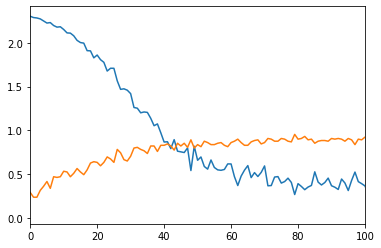

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(accuracy)
plt.xlim(0,200)



## Great, now your NN has been trained and validated! Now let's step up our debugging game with a pretrained resnet model. Be mindful when debugging as you are now working in a more modular enviroment with OOP!


In [ ]:
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)


In [ ]:
def bn_drop_lin(n_in, n_out, bn=True, p=0., actn=None):
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

In [ ]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)


In [ ]:
class Head(nn.Module):
    def __init__(self):
        super().__init__()

        pool = AdaptiveConcatPool2d()
        flat = Flatten()
        lin1 = bn_drop_lin(1024, 512, actn=nn.ReLU())
        lin2 = bn_drop_lin(512, 10)
        layers = [pool, flat] + lin1 + lin2
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, body, head):
        super().__init__()
        self.body = body
        self.head = head

    def forward(self, x):
        x = torch.cat([x,x,x], dim=1)
        return self.head(self.body(x))



In [ ]:
def get_model():

    body = nn.Sequential(*list(torchvision.models.resnet34(pretrained=True).children()))[:-2]
    head = Head()

    model = ConvNet(body, head)
    model.cuda()

    return model

In [ ]:
class ModelTrainer(object):
    
    def __init__(self):
        self.data, self.test = get_data()
        self.model = get_model()
        self.loss_fn = nn.CrossEntropyLoss()

    def freeze_to(self, n):

        for layer in self.model.body[:n]:
            if not isinstance(layer, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
                ps = list(layer.parameters())
                for p in ps:
                    p.requires_grad=False

        for layer in self.model.body[n:]:
            ps = list(layer.parameters())
            for p in ps:
                p.requires_grad = True


    def train(self, epochs, lr, decay=False):
        opt = optim.Adam(self.model.parameters(), lr=lr)

        for i in range(epochs):
            it = iter(self.data)
            print("Epoch {}/{}".format(i+1,epochs))
            for i, (x,y) in enumerate(it):
                x = x.cuda()
                y = y.cuda()

                predictions = self.model(x)

                opt.zero_grad()
                loss = self.loss_fn(predictions, y)
                loss.backward()
                opt.step()

                if i % 200 == 0:
                    print("Loss: {:.3f}".format(loss.item()))

                if decay:
                    opt.defaults['lr'] = opt.defaults['lr']*0.999

                def __init__(self):
                        self.losses = loss.item()
                def losses(self):   
                        return self.losses 

            self.validate()
            
    def validate(self):
        accuracy = []
        preds = []
        targs = []

        for i, (x,y) in enumerate(self.test):
            pred = self.model(x.cuda())
            preds.append(pred)
            targs.append(y.cuda())

        preds = torch.cat(preds, dim=0)
        targs = torch.cat(targs, dim=0)
        targs = targs.cuda()
        acc = (F.softmax(preds, dim=-1).argmax(-1) == targs.cuda()).float().mean()
        print("Accuracy: {:.3f}".format(acc.item()))


    def train_process(self):
        self.freeze_to(-1)
        self.train(3, 1e-3)
        self.freeze_to(-4)
        self.train(3, 1e-3, decay=True)
        self.freeze_to(0)
        self.train(3, 5e-4, decay=True)

        self.model.eval()
        self.validate()



In [ ]:
MT = ModelTrainer()

In [ ]:
MT.train_process()

Epoch 1/3
Loss: 2.477
Loss: 0.084
Loss: 0.232
Loss: 0.058
Loss: 0.095
Accuracy: 0.954
Epoch 2/3
Loss: 0.070
Loss: 0.181
Loss: 0.087
Loss: 0.019
Loss: 0.059
Accuracy: 0.959
Epoch 3/3
Loss: 0.035
Loss: 0.155
Loss: 0.053
Loss: 0.125
Loss: 0.150
Accuracy: 0.964
Epoch 1/3
Loss: 0.067
Loss: 0.124
Loss: 0.136
Loss: 0.054
Loss: 0.237
Accuracy: 0.987
Epoch 2/3
Loss: 0.040
Loss: 0.016
Loss: 0.005
Loss: 0.017
Loss: 0.043
Accuracy: 0.986
Epoch 3/3
Loss: 0.013
Loss: 0.042
Loss: 0.187
Loss: 0.019
Loss: 0.098
Accuracy: 0.988
Epoch 1/3
Loss: 0.013
Loss: 0.044
Loss: 0.024
Loss: 0.184
Loss: 0.010
Accuracy: 0.993
Epoch 2/3
Loss: 0.003
Loss: 0.002
Loss: 0.001
Loss: 0.001
Loss: 0.001
Accuracy: 0.992
Epoch 3/3
Loss: 0.049
Loss: 0.002
Loss: 0.001
Loss: 0.007
Loss: 0.006
Accuracy: 0.995
Accuracy: 0.994
